# ColorHandPose3D Demo

This notebook demos the ColorHandPose3d network as implemented in "Learning to Estimate 3D Hand Pose from Single RGB Images" by Zimmerman et al. Their project is available at [https://github.com/lmb-freiburg/hand3d].

In [1]:
import os
import sys
import math

import torch
import torchvision
import torch.nn.functional as F
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

model_path = os.path.abspath(os.path.join('..'))
if model_path not in sys.path:
    sys.path.append(model_path)
    
from colorhandpose3d.model.HandSegNet import HandSegNet
from colorhandpose3d.model.PoseNet import PoseNet
from colorhandpose3d.model.PosePrior import PosePrior
from colorhandpose3d.model.ViewPoint import ViewPoint
from colorhandpose3d.utils.general import *
from colorhandpose3d.utils.transforms import *

## Initialize models and load weights

ColorHandPose3d consists of 4 networks:
- HandSegNet
- PoseNet
- PosePrior
- ViewPointNet

In [2]:
handsegnet = HandSegNet()
posenet = PoseNet()
poseprior = PosePrior()
viewpoint = ViewPoint()

# Load weights
handsegnet.load_state_dict(torch.load('/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/handsegnet.pth.tar'))
posenet.load_state_dict(torch.load('/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/posenet.pth.tar'))
poseprior.load_state_dict(torch.load('/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/poseprior.pth.tar'))
viewpoint.load_state_dict(torch.load('/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/viewpoint.pth.tar'))

## Load and run sample

The network is trained on the RHD dataset.

In [39]:
transform0 = torchvision.transforms.ToPILImage()
transform1 = torchvision.transforms.ToTensor()
transform2 = torchvision.transforms.Resize(256)
img = Image.open('/home/ajdillhoff/Downloads/RHD_v1-1/RHD_published_v2/training/color/00005.png')
sample_original = transform1(transform2(img)).unsqueeze(0)
sample = sample_original - 0.5
hand_side = torch.Tensor([[1, 0]])

# Run through network
output = handsegnet.forward(sample)

# Calculate single highest scoring object
test_output = single_obj_scoremap(output, 21)

# Crop and resize
centers, bbs, crops = calc_center_bb(test_output)
crops = crops.to(torch.float32)
crop_size = 256

crops[0] *= 1.25
scale_crop = min(max(crop_size / crops[0], 0.25), 5.0)
image_crop = crop_image_from_xy(sample_original, centers, crop_size, scale_crop).squeeze()
mask_crop = crop_image_from_xy(test_output, centers, crop_size, scale_crop)

# also take a sample crop with mean subtracted
sample_crop = crop_image_from_xy(sample, centers, crop_size, scale_crop)

# PoseNet
keypoints_scoremap = posenet(sample_crop)
heatmaps = F.interpolate(keypoints_scoremap, 256, mode='bilinear', align_corners=False)
keypoint_coords_crop = detect_keypoints(heatmaps[0].detach().numpy())
keypoint_coords = transform_cropped_coords(keypoint_coords_crop, centers, scale_crop, crop_size)

# PosePrior
keypoint_coord3d = poseprior(keypoints_scoremap, hand_side)

# ViewPoint
rot_params = viewpoint(keypoints_scoremap, hand_side)

# Get normalized 3D coordinates
rot_matrix = get_rotation_matrix(rot_params)
cond_right = torch.eq(torch.argmax(hand_side, 1), 1)
cond_right_all = torch.reshape(cond_right, [-1, 1, 1]).repeat(1, 21, 3)
coords_xyz_can_flip = flip_right_hand(keypoint_coord3d, cond_right_all)
coords_xyz_rel_normed = coords_xyz_can_flip @ rot_matrix
keypoint_coords3d = coords_xyz_rel_normed.detach().numpy()
keypoint_coords3d = keypoint_coords3d.squeeze()

## Visualizing the output

Display the crop, heatmaps, and estimated pose.

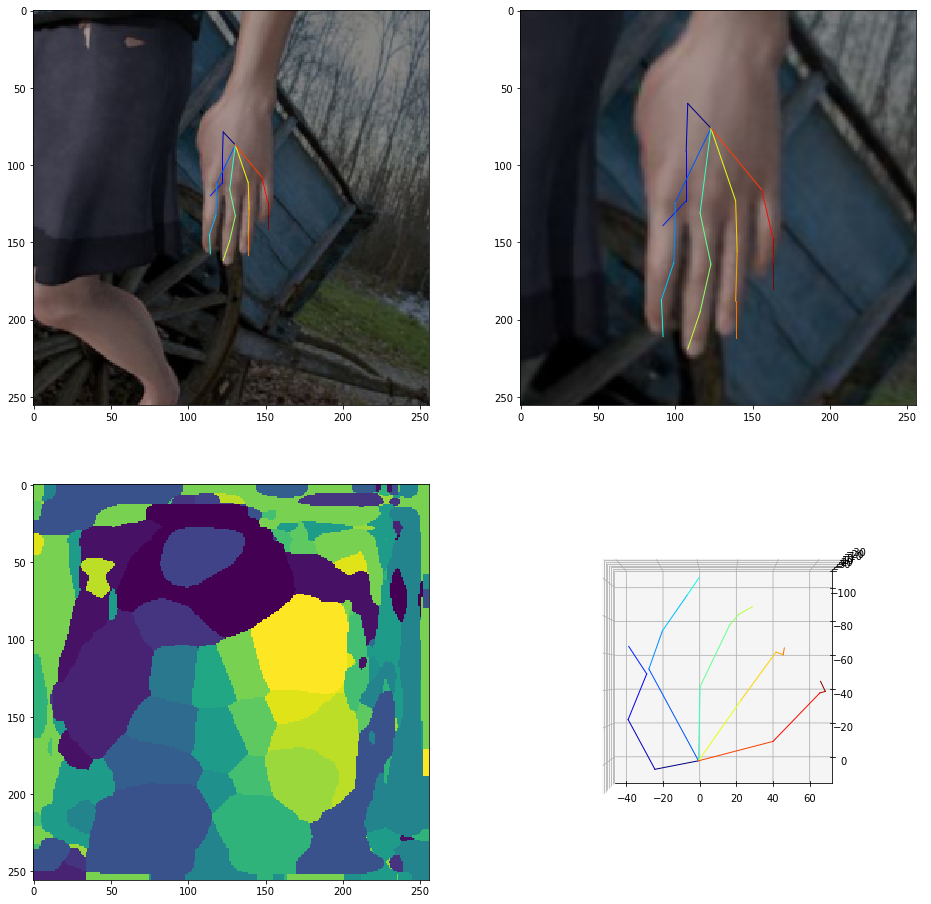

In [41]:
img = transform0(sample_original.squeeze())

# visualize
fig = plt.figure(1, figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224, projection='3d')
ax1.imshow(img)
plot_hand(keypoint_coords, ax1)
ax2.imshow(transform0(image_crop))
plot_hand(keypoint_coords_crop, ax2)
ax3.imshow(np.argmax(heatmaps[0].detach().numpy(), 0))
plot_hand_3d(keypoint_coords3d, ax4)
ax4.view_init(azim=-90.0, elev=-90.0)  # aligns the 3d coord with the camera view
plt.show()